### Exercice Machine Learning 

#### François Goujon

In [1]:
# Imports
import numpy as np  
import matplotlib.pyplot as plt 
import matplotlib.ticker as ticker
import pandas as pd
import os
import random
import math
import seaborn as sns
import time

from sklearn import preprocessing, model_selection
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegressionCV, RidgeClassifierCV
from sklearn.neural_network import MLPClassifier

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Dropout, MaxPooling1D, Flatten
from tensorflow.keras.callbacks import EarlyStopping

### Chargement des données et infos sur le dataset : 

In [2]:
dataset = pd.read_csv('Dataset.csv', delimiter=';')
print("Shape : ")
print(dataset.shape)

Shape : 
(310399, 16)


On vérifie quelques caractéristiques du dataset pour chacune des colonnes : Types des données, Nombre de valeurs, Nombre de valeurs distinctes, Nombre de valeurs manquantes, Ratio manquants, Valeurs possibles

In [3]:
def infodataset(data): 
    obs = data.shape[0]
    columns = pd.Series(data.columns.values)
    types = pd.Series(data.dtypes.values)
    counts = pd.Series(data.apply(lambda x: x.count()).values)
    uniques = pd.Series(data.apply(lambda x: [x.unique()]).values[0])
    nulls = pd.Series(data.apply(lambda x: x.isnull().sum()).values)
    distincts = pd.Series(data.apply(lambda x: x.unique().shape[0]).values)
    missing = pd.Series((data.isnull().sum()/ obs).values * 100 )
    print('Taille du dataset:', data.shape)
    
    cols = ['Colonnes','Types', 'Nombre de valeurs', 'Nombre de valeurs distinctes', 'Nombre de valeurs manquantes', 'Ratio manquants', 'Valeurs possibles']
    string = pd.concat([columns,types, counts, distincts, nulls, missing, uniques], axis = 1)
    
    string.columns = cols
    return string

In [4]:
pd.set_option('display.max_colwidth', None)
display(infodataset(dataset))

Taille du dataset: (310399, 16)


,Colonnes,Types,Nombre de valeurs,Nombre de valeurs distinctes,Nombre de valeurs manquantes,Ratio manquants,Valeurs possibles
0,Accessibilité de l'installation en faveur des personnes en situation de handicap,object,310157,3,242,0.077964,"[False, True, nan]"
1,Installation gardiennée,object,292666,3,17733,5.712969,"[False, True, nan]"
2,Installation gardiennée avec logement de gardien sur place,object,267817,3,42582,13.718472,"[False, nan, True]"
3,Possibilité d'hébergement dans l'installation,object,299980,3,10419,3.356647,"[False, True, nan]"
4,Installation implantée sur plusieurs communes,object,308543,3,1856,0.597940,"[False, True, nan]"
5,Possibilité de restauration dans l'installation,object,297651,3,12748,4.106972,"[False, True, nan]"
6,Nombre d'équipements rattachés à l'installation,float64,278002,57,32397,10.437211,"[3.0, 1.0, nan, 4.0, 6.0, 2.0, 13.0, 5.0, 10.0, 12.0, 8.0, 7.0, 11.0, 9.0, 22.0, 16.0, 26.0, 21.0, 25.0, 30.0, 15.0, 14.0, 27.0, 18.0, 17.0, 20.0, 38.0, 24.0, 42.0, 32.0, 23.0, 19.0, 33.0, 46.0, 28.0, 37.0, 47.0, 50.0, 36.0, 43.0, 40.0, 31.0, 35.0, 29.0, 56.0, 39.0, 51.0, 34.0, 49.0, 41.0, 59.0, 159.0, 60.0, 63.0, 44.0, 54.0, 70.0]"
7,Nombre de lits de l'installation,float64,307598,383,2801,0.902387,"[0.0, nan, 472.0, 442.0, 72.0, 6.0, 55.0, 10.0, 290.0, 250.0, 90.0, 900.0, 32.0, 37.0, 270.0, 230.0, 130.0, 100.0, 150.0, 200.0, 50.0, 12.0, 7.0, 80.0, 14.0, 73.0, 280.0, 86.0, 120.0, 110.0, 19.0, 204.0, 64.0, 228.0, 140.0, 85.0, 60.0, 149.0, 11.0, 27.0, 67.0, 40.0, 18.0, 36.0, 237.0, 20.0, 38.0, 2.0, 28.0, 88.0, 1.0, 199.0, 131.0, 4644.0, 108.0, 125.0, 35.0, 95.0, 232.0, 420.0, 800.0, 4.0, 186.0, 1411.0, 370.0, 175.0, 78.0, 66.0, 650.0, 325.0, 94.0, 224.0, 540.0, 190.0, 98.0, 330.0, 63.0, 42.0, 16.0, 142.0, 335.0, 695.0, 3000.0, 210.0, 600.0, 1800.0, 48.0, 180.0, 385.0, 982.0, 220.0, 34.0, 71.0, 630.0, 70.0, 156.0, 1000.0, 106.0, 183.0, 25.0, ...]"
8,Nombre de places de parking réservées à l'installation,float64,293793,366,16606,5.349888,"[30.0, 40.0, 20.0, 10.0, 50.0, 8.0, 5.0, 80.0, 160.0, 500.0, 100.0, 15.0, 2.0, 3.0, 4.0, 25.0, 70.0, 9.0, 0.0, 120.0, 60.0, nan, 35.0, 200.0, 150.0, 12.0, 18.0, 51.0, 48.0, 600.0, 142.0, 275.0, 650.0, 350.0, 56.0, 6.0, 24.0, 26.0, 23.0, 106.0, 90.0, 400.0, 58.0, 11.0, 110.0, 13.0, 280.0, 300.0, 250.0, 2000.0, 95.0, 105.0, 22.0, 1000.0, 38.0, 126.0, 130.0, 7.0, 1500.0, 1702.0, 36.0, 47.0, 92.0, 231.0, 32.0, 65.0, 28.0, 96.0, 55.0, 73.0, 39.0, 17.0, 52.0, 69.0, 45.0, 97.0, 140.0, 1.0, 16.0, 220.0, 148.0, 33.0, 29.0, 72.0, 125.0, 27.0, 21.0, 42.0, 291.0, 19.0, 31.0, 197.0, 244.0, 53.0, 94.0, 700.0, 75.0, 98.0, 85.0, 240.0, ...]"
9,Dont nombre de place de parking réservées aux personnes en situation de handicap,float64,289023,54,21376,6.886620,"[3.0, 0.0, 1.0, 2.0, 5.0, 10.0, 4.0, nan, 8.0, 12.0, 9.0, 20.0, 6.0, 15.0, 13.0, 40.0, 75.0, 25.0, 7.0, 22.0, 50.0, 56.0, 21.0, 76.0, 30.0, 60.0, 99.0, 14.0, 24.0, 11.0, 18.0, 35.0, 16.0, 31.0, 100.0, 90.0, 400.0, 65.0, 23.0, 29.0, 80.0, 140.0, 28.0, 64.0, 1000.0, 285.0, 46.0, 26.0, 42.0, 111.0, 39.0, 17.0, 70.0, 170.0]"


On remarque que l'on a 242 lignes sans valeur cible (colonne 0), nous les retirerons du dataset.

Dans la colonne 12 les valeurs ne sont pas considérées comme des Float64 comme pour les autres colonnes (à cause des espaces), il faudra repasser en Float64.

Pour la colonne 13, on remarque différente synthaxe pour la même chose : des écoles, des établissements sportifs, des etablissements penitentiaire et instalations militaire. Ces bâtiments étant publiques ils respectent généralement les mêmes normes de construction. Pour simplifier nous allons considérer seulement 2 valeurs possibles : lignes avec valeur non vide et les autres (les valeurs {}).

La colonne 14 semble donner trop d'indications pour résoudre le problème : il est possible que toutes les lignes avec colonne 0 = True aient un champ colonne 14 non vide et pas les autres. À vérifier, si c'est le cas on retirera cette colonne du dataset.

Pour la colonne 15, on remarque plusieurs moyens de transport : Bus, Train, Tramway, Métro, Autre, Bateau et des valeurs vides {} dont on présume qu'elles représentent aucun transport en commun. Il y a aussi des valeurs non définies NaN.
Le mieux serait de procéder par One Hot Encoding : créer une colonne par moyen de transport et de remplir par 0 ou 1.

Pour les valeurs NaN, dans les colonnes à valeur numérique on utilisera la médianne des valeurs pour remplacer la valeur NaN.
Pour les autres colonnes, on pourra dans un premier temps simplement essayer de retirer les lignes correspondantes au vu du faible nombre de données manquantes dans chaque colonne en comparaison avec la taille du dataset.

Si cela donne un dataset de trop petite taille, on pourra utilser d'autres méthodes pour traiter les NaN.

#### On vérifie si colonne14 différent de nan implique que colonne 0 soit True : 

In [5]:
nb_14nan_0true = 0
nb_14nan_0false = 0
nb_14notnan_0true = 0
nb_14notnan_0false = 0
for i in range(dataset.shape[0]):
    if (type(dataset.iloc[i][14]) == np.float):
        if (dataset.iloc[i][0]):
            nb_14nan_0true += 1;
        else :
            nb_14nan_0false += 1;
    else :
        if (dataset.iloc[i][0]):
            nb_14notnan_0true += 1;
        else :
            nb_14notnan_0false += 1;
        
        
print(f'Nombre NaN et True : {nb_14nan_0true} ; Nombre NaN et False : {nb_14nan_0false} ; Nombre Not NaN et True : {nb_14notnan_0true} ; Nombre Not NaN et False : {nb_14notnan_0false}')


Nombre NaN et True : 313 ; Nombre NaN et False : 13851 ; Nombre Not NaN et True : 201521 ; Nombre Not NaN et False : 94714


On remarque que globalement lorsqu'il y a NaN en 14, il y False en 0 et que lorsqu'il Not NaN en 14, il y 2 fois plus souvent True que False.
On vérifie maintenant si colonne 14 contient "Handicap moteur" implique colonne 0 soit True :

In [6]:
nb_14moteur_0true = 0
nb_14moteur_0false = 0
nb_14autre_0true = 0
nb_14autre_0false = 0
for i in range(dataset.shape[0]):
    if (type(dataset.iloc[i,14]) != np.float):
        if ('"Handicap moteur"' in dataset.iloc[i,14]):
            if (dataset.iloc[i][0]):
                nb_14moteur_0true += 1;
            else :
                nb_14moteur_0false += 1;
        else :
            if (dataset.iloc[i][0]):
                nb_14autre_0true += 1;
            else :
                nb_14autre_0false += 1;
    else :
        if (dataset.iloc[i][0]):
            nb_14autre_0true += 1;
        else :
            nb_14autre_0false += 1;
            
print(f'Moteur et True : {nb_14moteur_0true} ; Moteur et False : {nb_14moteur_0false} ; Autre et True : {nb_14autre_0true} ; Autre et False : {nb_14autre_0false}')


Moteur et True : 199312 ; Moteur et False : 347 ; Autre et True : 2522 ; Autre et False : 108218


On remarque cette fois ci une très forte corrélation entre la présence de "Handicap moteur" en 14 et True en 0 comme nous l'avions prévu.

##### Nous allons donc enlever cette colonne de notre dataset pour ne pas rendre la tache trop facile.

# Data cleaning

In [5]:
# Drop de la colonne 14 : Accessibilité de l'installation en fonction du type handicap
dataset.drop(columns= "Accessibilité de l'installation en fonction du type handicap", inplace=True)

# On enlève les valeurs inconsistantes de la colonne 12 : il y a quelques lignes où l'unité apparait.
# Étant donné que cela concerne très peu de ligne on va simplement les supprimer

indicedrop=[]
i = 0
count = 0
for i in range(dataset.shape[0]):
    val = dataset.iloc[i,12]
    if type(val) != np.float:
        if "h" in val or "H" in val or "m" in val or "m²" in val or "M" in val or "O" in val or "o" in val:  #certain 0 sont en réalité des O
            indicedrop.append(i)
            count += 1
            
dataset.drop(labels=indicedrop, inplace =True)
print(f'Nombre de lignes enlevées : {count}')

# On change de type des données de la colonne 12

# On enlève les espaces et on converti en float
dataset["Emprise foncière de l'installation"] = [float(str(val).replace(' ','').replace(',','.')) for val in dataset["Emprise foncière de l'installation"].values]
print(dataset.dtypes[12]) # Type bien modifié

Nombre de lignes enlevées : 90
float64


In [6]:
# On enlève les lignes où le label colonne 0 est NaN
tailleavant = dataset.shape[0]
dataset.dropna(axis=0, subset=["Accessibilité de l'installation en faveur des personnes en situation de handicap"], inplace=True)
tailleapres = dataset.shape[0]
dif = tailleavant - tailleapres
print(f'Nombre de lignes enlevées : {dif}')
dataset.reset_index(inplace=True, drop = True)

Nombre de lignes enlevées : 242


### On vérifie les outliers et supprime des lignes si nécessaire pour ne pas altérer la normalisation des données numériques que l'on effectuera

In [7]:
def plot_boxplot(dataset, nom):
    ig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    
    sns.boxplot(x=dataset[nom], ax = axes[0])
    sns.boxplot(x=dataset[nom], showfliers = False, ax = axes[1])
    
    plt.show()
    
    Q1 = dataset[nom].quantile(0.25)
    Q3 = dataset[nom].quantile(0.75)
    IQR = Q3 - Q1   

    count = dataset[nom][dataset[nom] > Q3 + 1.5 *IQR].count()  
    print(f'Nombre de outliers {count}')
    
def proportionSupLim(dataset, nom, init, pas, fin):
    i = 0
    count=1
    taille = dataset[nom].count()
    listey = []
    listex = []
    while count > 0 and init + i*pas < fin :
        listex.append(init + i*pas)
        count = dataset[nom][dataset[nom] > init + i*pas].count()
        listey.append(count/taille)
        #print(f'Proportion supérieur à {limite + i*pas} : {count/taille}')
        i += 1
    plt.plot(listex, listey)
    plt.xlabel('Limite')
    plt.ylabel('Proportion > limite')
    plt.show()
    
# Si on ne donne pas de paramètre limite on supprime les outliers suivant val > > Q3 + 1.5 *IQR
# Si on donne un paramètre limite on supprime suivant val > limite
def dropoutliers(dataset, nom, limite = None):
    if limite == None :
        Q1 = dataset[nom].quantile(0.25)
        Q3 = dataset[nom].quantile(0.75)
        IQR = Q3 - Q1   
        indexdrop = dataset[nom][dataset[nom] > Q3 + 1.5 *IQR].index

        tailleavant = dataset.shape[0]
        dataset.drop(index=indexdrop, inplace =True)
        tailleapres = dataset.shape[0]
        dif = tailleavant - tailleapres
        print(f'Ligne enlevées : {dif} ; Nouvelle taille : {tailleapres}')
    else :
        indexdrop = dataset[nom][dataset[nom] > limite].index
        tailleavant = dataset.shape[0]
        dataset.drop(index=indexdrop, inplace =True)
        tailleapres = dataset.shape[0]
        dif = tailleavant - tailleapres
        print(f'Ligne enlevées : {dif} ; Nouvelle taille : {tailleapres}')
    
    dataset.reset_index(inplace=True, drop = True)
    

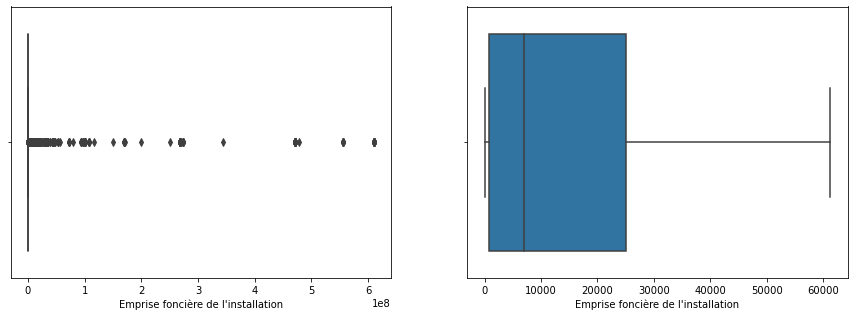

Nombre de outliers 23687


In [7]:
plot_boxplot(dataset, "Emprise foncière de l'installation")

Il y a beaucoup d'outliers, on va éviter de tous les suprimer et on va chercher à partir de combien il n'y en a réellement plus beaucoup.

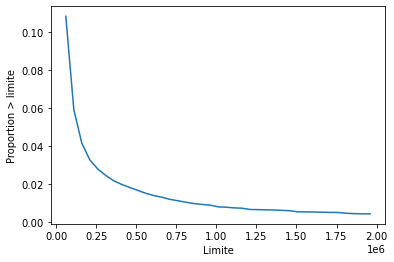

In [8]:
proportionSupLim(dataset, "Emprise foncière de l'installation", 60000, 50000, 2000000)

On voit qu'il y a un coude à environ 300 000, on va donc supprimer ceux après ce seuil.

In [6]:
dropoutliers(dataset, "Emprise foncière de l'installation", limite = 300000)

Ligne enlevées : 5460 ; Nouvelle taille : 304607


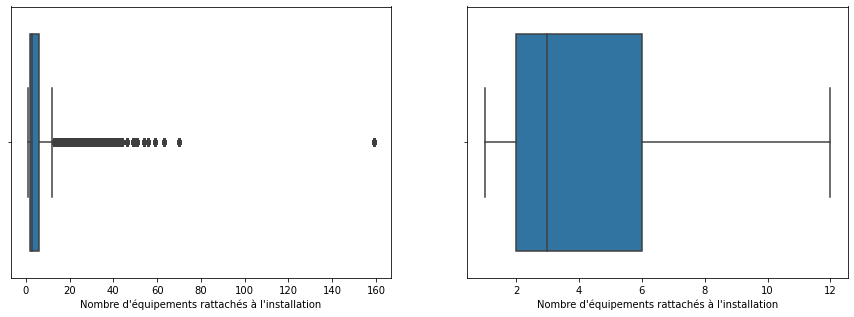

Nombre de outliers 22673


In [10]:
plot_boxplot(dataset, "Nombre d'équipements rattachés à l'installation")

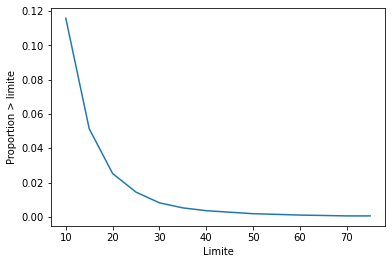

In [11]:
proportionSupLim(dataset, "Nombre d'équipements rattachés à l'installation", 10, 5, 80)

In [7]:
dropoutliers(dataset, "Nombre d'équipements rattachés à l'installation", limite = 30)

Ligne enlevées : 2242 ; Nouvelle taille : 302365


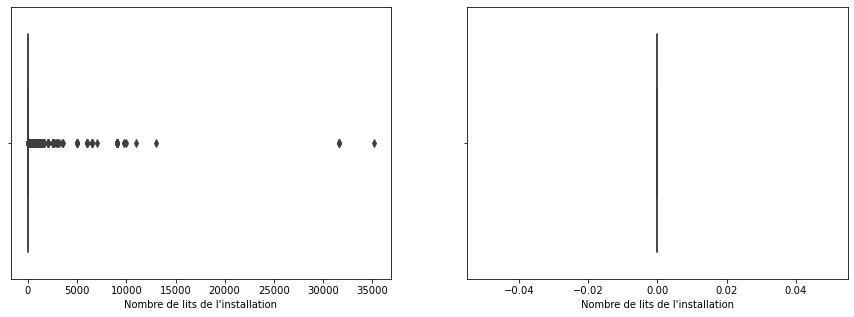

Nombre de outliers 12537


In [13]:
plot_boxplot(dataset, "Nombre de lits de l'installation")

Ici, drop tous les outliers voudrait dire considérer seulement les installations avec 0 lits. 
Nous allons essayer de drop seulement les cas les plus extrêmes.

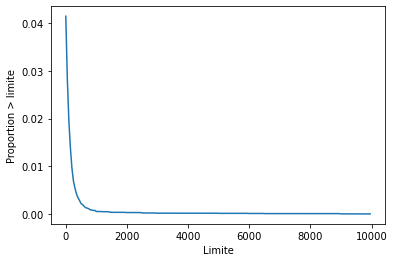

In [14]:
proportionSupLim(dataset, "Nombre de lits de l'installation", 1, 50, 10000)

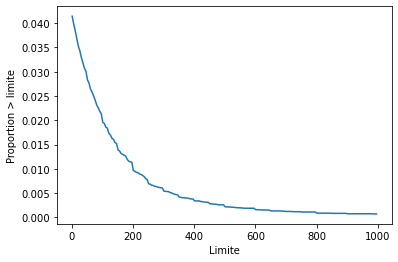

In [15]:
proportionSupLim(dataset, "Nombre de lits de l'installation", 1, 5, 1000)

On voit qu'il n'y a que peu d'installation à plus de 500 lits, on supprime celles ci.

In [8]:
dropoutliers(dataset, "Nombre de lits de l'installation", limite=500)

Ligne enlevées : 661 ; Nouvelle taille : 301704


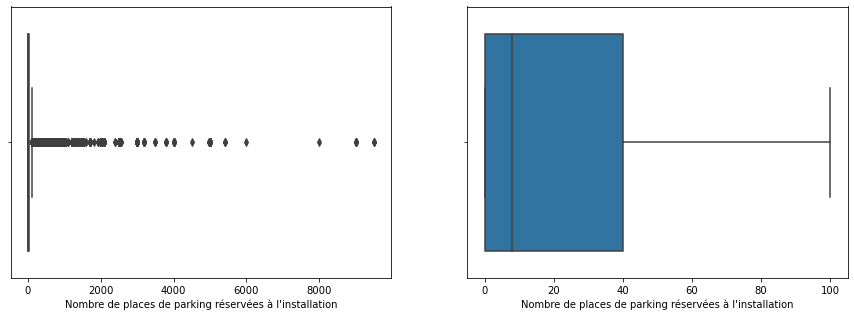

Nombre de outliers 19370


In [17]:
plot_boxplot(dataset, "Nombre de places de parking réservées à l'installation")

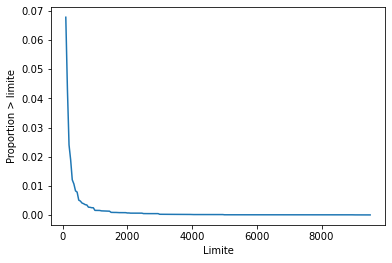

In [18]:
proportionSupLim(dataset, "Nombre de places de parking réservées à l'installation", 100, 50, 10000)

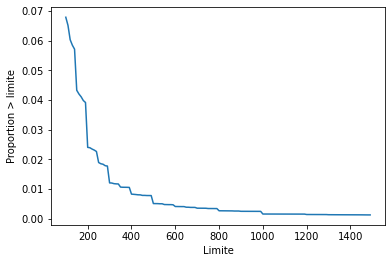

In [19]:
proportionSupLim(dataset, "Nombre de places de parking réservées à l'installation", 100, 10, 1500)

In [9]:
dropoutliers(dataset, "Nombre de places de parking réservées à l'installation", limite = 500)

Ligne enlevées : 1450 ; Nouvelle taille : 300254


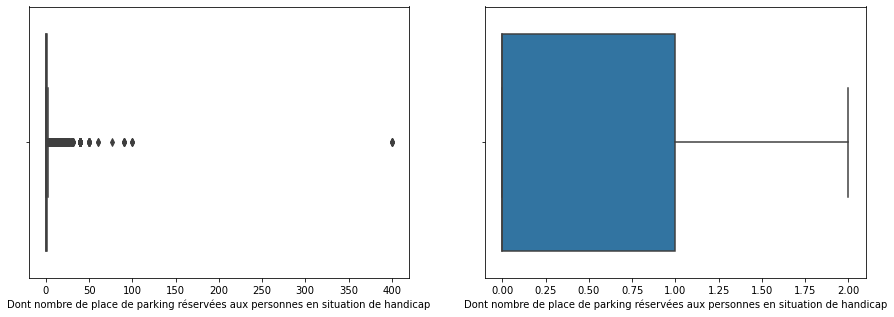

Nombre de outliers 23204


In [21]:
plot_boxplot(dataset, 'Dont nombre de place de parking réservées aux personnes en situation de handicap')

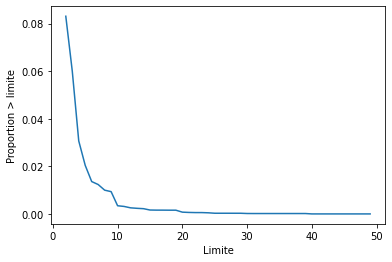

In [22]:
proportionSupLim(dataset, 'Dont nombre de place de parking réservées aux personnes en situation de handicap', 2, 1, 50)

In [10]:
#On drop pour > 10
dropoutliers(dataset, "Dont nombre de place de parking réservées aux personnes en situation de handicap", limite=10)

Ligne enlevées : 985 ; Nouvelle taille : 299269


In [8]:
# Pour tout drop d'un coup
dropoutliers(dataset, "Emprise foncière de l'installation", limite = 300000)
dropoutliers(dataset, "Nombre d'équipements rattachés à l'installation", limite = 30)
dropoutliers(dataset, "Nombre de lits de l'installation", limite=500)
dropoutliers(dataset, "Nombre de places de parking réservées à l'installation", limite = 500)
dropoutliers(dataset, "Dont nombre de place de parking réservées aux personnes en situation de handicap", limite=10)

Ligne enlevées : 5460 ; Nouvelle taille : 304607
Ligne enlevées : 2242 ; Nouvelle taille : 302365
Ligne enlevées : 661 ; Nouvelle taille : 301704
Ligne enlevées : 1450 ; Nouvelle taille : 300254
Ligne enlevées : 985 ; Nouvelle taille : 299269


#### Pour les valeurs NaN dans les catégories à valeurs numériques on utilisera la médiane des valeurs de la colonne pour remplacer.
#### Pour les valeurs NaN dans les catégories à valeurs booléenes, nous allons supprimer les lignes

In [9]:
def HandleNaN(dataset):
    float_cols = [nom for nom in dataset.columns if dataset[nom].dtype == 'float64']
    obj_cols = [nom for nom in dataset.columns if dataset[nom].dtype == "object"]
    values = {}
    # On remplace par la médiane pour les colonnes à valeurs float
    for nom in float_cols:
        values[nom] = dataset[nom].median()
    
    # Pour les colonnes à valeur booléene, on supprime la ligne
    for nom in obj_cols:
        dataset.dropna(axis=0, subset=[nom], inplace=True)
        
    dataset.fillna(value=values,inplace=True)
    dataset.reset_index(inplace=True, drop = True)

In [10]:
HandleNaN(dataset)
print(dataset.isnull().sum().sum()) # On a bien supprimé toutes les valeurs NaN
print(dataset.shape[0]) # La taille du dataset reste bonne
display(dataset)

0
236812


,Accessibilité de l'installation en faveur des personnes en situation de handicap,Installation gardiennée,Installation gardiennée avec logement de gardien sur place,Possibilité d'hébergement dans l'installation,Installation implantée sur plusieurs communes,Possibilité de restauration dans l'installation,Nombre d'équipements rattachés à l'installation,Nombre de lits de l'installation,Nombre de places de parking réservées à l'installation,Dont nombre de place de parking réservées aux personnes en situation de handicap,Accessibilité de l'installation en transport en commun,Installation particulière,Emprise foncière de l'installation,Type de particularité de l'installation,Accessibilité de l'installation en transport en commun des différents mode
0,False,False,False,False,False,False,3.0,0.0,30.0,3.0,True,False,6100.0,{},{}
1,True,False,False,False,False,False,3.0,0.0,40.0,0.0,True,False,12450.0,{},{}
2,False,False,False,False,False,False,1.0,0.0,20.0,0.0,True,False,6100.0,{},{}
3,False,False,False,False,True,False,4.0,0.0,10.0,0.0,True,False,6100.0,{},{}
4,False,False,False,False,True,False,4.0,0.0,10.0,0.0,True,False,6100.0,{},{}
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236807,False,False,False,False,False,False,2.0,0.0,0.0,0.0,True,True,6100.0,"{""Etablissement scolaire""}",{}
236808,False,False,False,False,False,False,2.0,0.0,50.0,0.0,True,False,6100.0,{},{}
236809,False,False,False,False,False,False,1.0,0.0,50.0,0.0,True,True,6100.0,"{""Etablissement scolaire""}",{}
236810,False,False,False,False,False,False,2.0,0.0,50.0,0.0,True,False,6100.0,{},{}


Il reste à gérer la colonne 13 concernant le type d'installation et la dernière colonne (devenue 14) concernant les transports en commun.

In [11]:
def HandleTypeInstallation(dataset):
    dataset["Type de particularité de l'installation"][dataset["Type de particularité de l'installation"] != "{}"] = 1
    dataset["Type de particularité de l'installation"].replace(to_replace = "{}", value = 0, inplace = True)
    
def HandleModeTransport(dataset):
    taille = dataset.shape[0]
    Bus = np.zeros(taille, dtype = np.int64)
    Train = np.zeros(taille, dtype = np.int64) 
    Tramway = np.zeros(taille, dtype = np.int64) 
    Metro = np.zeros(taille, dtype = np.int64) 
    Autre = np.zeros(taille, dtype = np.int64)
    Bateau = np.zeros(taille, dtype = np.int64)
    Aucun = np.zeros(taille, dtype = np.int64)
    listearray = [Bus, Train, Tramway, Metro, Autre, Bateau]
    liste = ["Bus", "Train", "Tramway", "Métro", "Autre", "Bateau"]
    for i in range(taille):
        string = dataset.iloc[i,14]
        if string == "{}":
            Aucun[i] = 1
        for j in range(len(liste)):
            mot = liste[j]
            if mot in string :
                listearray[j][i] = 1
    dataset['Aucun'] = Aucun
    for i in range(len(liste)):
        dataset[liste[i]] = listearray[i]
        

In [12]:
HandleTypeInstallation(dataset)
HandleModeTransport(dataset)

# On peut maintenant drop la colonne des transports
dataset.drop(columns="Accessibilité de l'installation en transport en commun des différents mode", inplace=True)
display(dataset)

<ipython-input-11-cb4cf9263ce9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["Type de particularité de l'installation"][dataset["Type de particularité de l'installation"] != "{}"] = 1


,Accessibilité de l'installation en faveur des personnes en situation de handicap,Installation gardiennée,Installation gardiennée avec logement de gardien sur place,Possibilité d'hébergement dans l'installation,Installation implantée sur plusieurs communes,Possibilité de restauration dans l'installation,Nombre d'équipements rattachés à l'installation,Nombre de lits de l'installation,Nombre de places de parking réservées à l'installation,Dont nombre de place de parking réservées aux personnes en situation de handicap,...,Installation particulière,Emprise foncière de l'installation,Type de particularité de l'installation,Aucun,Bus,Train,Tramway,Métro,Autre,Bateau
0,False,False,False,False,False,False,3.0,0.0,30.0,3.0,...,False,6100.0,0,1,0,0,0,0,0,0
1,True,False,False,False,False,False,3.0,0.0,40.0,0.0,...,False,12450.0,0,1,0,0,0,0,0,0
2,False,False,False,False,False,False,1.0,0.0,20.0,0.0,...,False,6100.0,0,1,0,0,0,0,0,0
3,False,False,False,False,True,False,4.0,0.0,10.0,0.0,...,False,6100.0,0,1,0,0,0,0,0,0
4,False,False,False,False,True,False,4.0,0.0,10.0,0.0,...,False,6100.0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236807,False,False,False,False,False,False,2.0,0.0,0.0,0.0,...,True,6100.0,1,1,0,0,0,0,0,0
236808,False,False,False,False,False,False,2.0,0.0,50.0,0.0,...,False,6100.0,0,1,0,0,0,0,0,0
236809,False,False,False,False,False,False,1.0,0.0,50.0,0.0,...,True,6100.0,1,1,0,0,0,0,0,0
236810,False,False,False,False,False,False,2.0,0.0,50.0,0.0,...,False,6100.0,0,1,0,0,0,0,0,0


Il reste à changer les False par 0, les True par 1 et normaliser les colonnes numériques

In [13]:
def normalisation(dataset, nomcolonne):
    data = dataset[nomcolonne].values 
    data = data.reshape(-1, 1)
    min_max_scaler = preprocessing.MinMaxScaler()
    data_scaled = min_max_scaler.fit_transform(data)
    data_scaled = data_scaled.reshape(data_scaled.shape[0])
    dataset[nomcolonne] = pd.Series(data_scaled)

In [14]:
normalisation(dataset, "Nombre d'équipements rattachés à l'installation")
normalisation(dataset, "Nombre de lits de l'installation")
normalisation(dataset, "Nombre de places de parking réservées à l'installation")
normalisation(dataset, "Dont nombre de place de parking réservées aux personnes en situation de handicap")
normalisation(dataset, "Emprise foncière de l'installation")
display(dataset)

,Accessibilité de l'installation en faveur des personnes en situation de handicap,Installation gardiennée,Installation gardiennée avec logement de gardien sur place,Possibilité d'hébergement dans l'installation,Installation implantée sur plusieurs communes,Possibilité de restauration dans l'installation,Nombre d'équipements rattachés à l'installation,Nombre de lits de l'installation,Nombre de places de parking réservées à l'installation,Dont nombre de place de parking réservées aux personnes en situation de handicap,...,Installation particulière,Emprise foncière de l'installation,Type de particularité de l'installation,Aucun,Bus,Train,Tramway,Métro,Autre,Bateau
0,False,False,False,False,False,False,0.068966,0.0,0.06,0.3,...,False,0.020333,0,1,0,0,0,0,0,0
1,True,False,False,False,False,False,0.068966,0.0,0.08,0.0,...,False,0.041500,0,1,0,0,0,0,0,0
2,False,False,False,False,False,False,0.000000,0.0,0.04,0.0,...,False,0.020333,0,1,0,0,0,0,0,0
3,False,False,False,False,True,False,0.103448,0.0,0.02,0.0,...,False,0.020333,0,1,0,0,0,0,0,0
4,False,False,False,False,True,False,0.103448,0.0,0.02,0.0,...,False,0.020333,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236807,False,False,False,False,False,False,0.034483,0.0,0.00,0.0,...,True,0.020333,1,1,0,0,0,0,0,0
236808,False,False,False,False,False,False,0.034483,0.0,0.10,0.0,...,False,0.020333,0,1,0,0,0,0,0,0
236809,False,False,False,False,False,False,0.000000,0.0,0.10,0.0,...,True,0.020333,1,1,0,0,0,0,0,0
236810,False,False,False,False,False,False,0.034483,0.0,0.10,0.0,...,False,0.020333,0,1,0,0,0,0,0,0


In [15]:
dataset.replace(to_replace = True, value = 1, inplace = True)
dataset.replace(to_replace = False, value = 0, inplace = True)
dataset.head()

,Accessibilité de l'installation en faveur des personnes en situation de handicap,Installation gardiennée,Installation gardiennée avec logement de gardien sur place,Possibilité d'hébergement dans l'installation,Installation implantée sur plusieurs communes,Possibilité de restauration dans l'installation,Nombre d'équipements rattachés à l'installation,Nombre de lits de l'installation,Nombre de places de parking réservées à l'installation,Dont nombre de place de parking réservées aux personnes en situation de handicap,...,Installation particulière,Emprise foncière de l'installation,Type de particularité de l'installation,Aucun,Bus,Train,Tramway,Métro,Autre,Bateau
0,0,0,0,0,0,0,0.068966,0.0,0.06,0.3,...,0,0.020333,0,1,0,0,0,0,0,0
1,1,0,0,0,0,0,0.068966,0.0,0.08,0.0,...,0,0.041500,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0.000000,0.0,0.04,0.0,...,0,0.020333,0,1,0,0,0,0,0,0
3,0,0,0,0,1,0,0.103448,0.0,0.02,0.0,...,0,0.020333,0,1,0,0,0,0,0,0
4,0,0,0,0,1,0,0.103448,0.0,0.02,0.0,...,0,0.020333,0,1,0,0,0,0,0,0


In [16]:
infodataset(dataset)

Taille du dataset: (236812, 21)


,Colonnes,Types,Nombre de valeurs,Nombre de valeurs distinctes,Nombre de valeurs manquantes,Ratio manquants,Valeurs possibles
0,Accessibilité de l'installation en faveur des personnes en situation de handicap,int64,236812,2,0,0.0,"[0, 1]"
1,Installation gardiennée,int64,236812,2,0,0.0,"[0, 1]"
2,Installation gardiennée avec logement de gardien sur place,int64,236812,2,0,0.0,"[0, 1]"
3,Possibilité d'hébergement dans l'installation,int64,236812,2,0,0.0,"[0, 1]"
4,Installation implantée sur plusieurs communes,int64,236812,2,0,0.0,"[0, 1]"
5,Possibilité de restauration dans l'installation,int64,236812,2,0,0.0,"[0, 1]"
6,Nombre d'équipements rattachés à l'installation,float64,236812,30,0,0.0,"[0.06896551724137931, 0.0, 0.10344827586206896, 0.1724137931034483, 0.034482758620689655, 0.41379310344827586, 0.13793103448275862, 0.3103448275862069, 0.3793103448275862, 0.24137931034482757, 0.2068965517241379, 0.3448275862068965, 0.27586206896551724, 0.7241379310344828, 0.5172413793103449, 0.8620689655172414, 0.8275862068965517, 0.4827586206896552, 0.44827586206896547, 0.896551724137931, 0.5862068965517242, 0.5517241379310345, 0.6551724137931035, 0.7931034482758621, 0.6896551724137931, 0.7586206896551725, 0.6206896551724138, 0.9310344827586207, 1.0, 0.9655172413793104]"
7,Nombre de lits de l'installation,float64,236812,272,0,0.0,"[0.0, 0.58, 0.064, 0.074, 0.54, 0.46, 0.012, 0.26, 0.2, 0.5, 0.3, 0.4, 0.1, 0.024, 0.014, 0.02, 0.16, 0.028, 0.146, 0.17200000000000001, 0.24, 0.038, 0.28, 0.298, 0.022, 0.134, 0.08, 0.036000000000000004, 0.07200000000000001, 0.004, 0.04, 0.056, 0.22, 0.176, 0.002, 0.054, 0.14400000000000002, 0.398, 0.12, 0.07, 0.18, 0.464, 0.84, 0.17, 0.008, 0.076, 0.372, 0.66, 0.126, 0.084, 0.032, 0.28400000000000003, 0.19, 0.67, 0.42, 0.25, 0.096, 0.56, 0.36, 0.44, 0.068, 0.14200000000000002, 0.366, 0.05, 0.10400000000000001, 0.38, 0.228, 0.016, 0.192, 0.124, 0.9, 0.668, 0.044, 0.088, 0.01, 0.06, 0.21, 0.232, 0.194, 0.6, 0.492, 0.006, 0.364, 0.14, 0.112, 0.244, 0.444, 0.5700000000000001, 0.488, 0.20400000000000001, 0.772, 0.08600000000000001, 0.058, 0.188, 0.11, 0.042, 0.13, 0.034, 0.15, 0.52, ...]"
8,Nombre de places de parking réservées à l'installation,float64,236812,256,0,0.0,"[0.06, 0.08, 0.04, 0.02, 0.1, 0.016, 0.01, 0.16, 0.03, 0.006, 0.14, 0.018000000000000002, 0.05, 0.24, 0.12, 0.2, 0.0, 0.012, 0.07, 0.4, 0.3, 0.024, 0.004, 0.10200000000000001, 0.096, 0.28400000000000003, 0.55, 0.7000000000000001, 0.008, 0.112, 0.048, 0.052000000000000005, 0.046, 0.212, 0.18, 0.036000000000000004, 0.8, 0.022, 0.56, 0.5, 0.19, 0.21, 0.044, 0.076, 0.252, 0.6, 0.26, 0.014, 0.07200000000000001, 0.094, 0.184, 0.462, 0.32, 0.064, 0.13, 1.0, 0.056, 0.192, 0.11, 0.146, 0.078, 0.034, 0.10400000000000001, 0.138, 0.09, 0.194, 0.28, 0.002, 0.032, 0.296, 0.066, 0.058, 0.14400000000000002, 0.25, 0.026000000000000002, 0.054, 0.042, 0.084, 0.582, 0.038, 0.062, 0.394, 0.188, 0.15, 0.196, 0.48, 0.22, 0.128, 0.218, 0.074, 0.082, 0.068, 0.276, 0.20600000000000002, 0.132, 0.152, 0.35000000000000003, 0.34, 0.116, 0.312, ...]"
9,Dont nombre de place de parking réservées aux personnes en situation de handicap,float64,236812,11,0,0.0,"[0.30000000000000004, 0.0, 0.1, 0.4, 0.2, 1.0, 0.8, 0.5, 0.9, 0.6000000000000001, 0.7000000000000001]"


In [17]:
# On récupère la colonne que l'on cherche à prédire
labels = dataset["Accessibilité de l'installation en faveur des personnes en situation de handicap"]

In [18]:
# On récupère les données sans label
X = dataset.iloc[:,1:]

## Le dataset est maintenant prêt à être utilisé

In [19]:
# On sépare les donnés en set de train, validation et test
# Certains algorithmes nécessite d'avoir seulement un set train et test car la validation est
# faite automatiquement par cross validation

# On fait donc Train(70%) et Test(30%) et on recoupe Test en deux : Val(15%) et Test2(15%)

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, labels, test_size=0.30, random_state=1)

X_val, X_test2, y_val, y_test2 = model_selection.train_test_split(X_test, y_test, test_size=0.5, random_state=1)

print("Shape train et test")
print(X_train.shape[0])
print(X_test.shape[0])
print("\nShape val et test2")
print(X_val.shape[0])
print(X_test2.shape[0])

Shape train et test
165768
71044

Shape val et test2
35522
35522


## LDA

On vérifie rapidement via LDA sur une composante si les données sont bien séparées

In [19]:
def reducLDA(X, y, components=1) :
    lda = LinearDiscriminantAnalysis(n_components=components)
    X_lda = lda.fit_transform(X, y)
    
    return X_lda, lda
    
    
# Fonction d'affichage du LDA des primitives en 2D

def affichageLDA(X_lda, y):
    plt.figure()
    
    plt.scatter(X_lda[y == 0, 0], np.zeros_like(X_lda[y == 0, 0]), alpha=.8, c='navy',
                label="Pas d'accès handicap")
    plt.scatter(X_lda[y == 1, 0], np.ones_like(X_lda[y == 1, 0]), alpha=.8, c='darkorange',
                label="Accès Handicap")
    plt.legend(loc='best', shadow=False, scatterpoints=1)
    plt.title("LDA on dataset")

    plt.show()

In [20]:
X_train_lda, lda = reducLDA(X_train, y_train)

In [21]:
print(X_train_lda.shape)

(165768, 1)


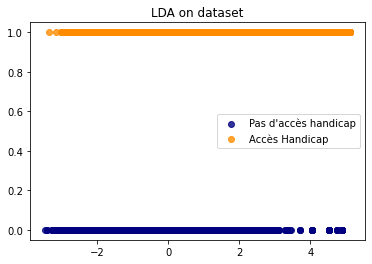

In [22]:
affichageLDA(X_train_lda, y_train)

In [23]:
lda.score(X_test, y_test)

0.674722707054783

En 1D les données ne sont pas bien séparées (ne pas se fier à l'ordonnée qui permet juste d'éviter la superpositions des points). Cohérent, 1 dimension ne suffit pas. On note quand même un pourcentage de 67% de bonne classification sur l'ensemble de test avec un simple LDA.

# Modeles :

In [24]:
def fitmodels(liste_model, liste_nom, X_train, y_train):
    liste_temps = []
    for i in range(len(liste_model)):
        avant = time.time()
        liste_model[i].fit(X_train, y_train)
        apres = time.time()
        dif = apres - avant
        liste_temps.append(dif)
        print(f'Temps éxecution {liste_nom[i]} : {dif} secondes')
    return liste_temps
      
              
def scoremodels(liste_model, liste_nom, X_test, y_test):
    liste_score = []
    for i in range(len(liste_model)):
        score = liste_model[i].score(X_test, y_test)
        print("---------------------------------")
        print(f'{liste_nom[i]} score : {score}')
        liste_score.append(score)
    return liste_score

## Modèles :

Nous allons essayer différents types de modèles (linéaire, arbre de décision, ensemblistes, réseaux de neuronnes) en testant différents paramètres à chaque fois. 

## Logistic Regression et Ridge

In [40]:
# On utilise un modele de régression logistique avec cross validation intégrée
# On utilise le 5-fold avec différents solver
classifier_lbfgs = LogisticRegressionCV(cv=5, solver='lbfgs', max_iter = 1000)
classifier_saga = LogisticRegressionCV(cv=5, solver='saga', max_iter = 500)
classifier_saga_elasticnet = LogisticRegressionCV(cv=5, solver='saga', penalty = 'elasticnet', max_iter = 500,l1_ratios=[0.25, 0.5,0.75])
classifier_sag = LogisticRegressionCV(cv=5, solver='sag', max_iter = 500)
classifier_mlp = MLPClassifier(max_iter=400)


liste_LogReg = [classifier_lbfgs, classifier_saga, classifier_saga_elasticnet, classifier_sag, classifier_mlp]
liste_LogRegStr = ["classifier_lbfgs", "classifier_saga", "classifier_saga_elasticnet", "classifier_sag", "classifier_mlp"]

In [41]:
temps_logreg = fitmodels(liste_LogReg, liste_LogRegStr, X_train, y_train)

Temps éxecution classifier_lbfgs : 20.53488516807556 secondes
Temps éxecution classifier_saga : 171.46857333183289 secondes
Temps éxecution classifier_saga_elasticnet : 642.5169620513916 secondes
Temps éxecution classifier_sag : 102.56402802467346 secondes
Temps éxecution classifier_mlp : 142.2826111316681 secondes


In [42]:
scores_logreg = scoremodels(liste_LogReg, liste_LogRegStr, X_test, y_test)

---------------------------------
classifier_lbfgs score : 0.6743673904505414
---------------------------------
classifier_saga score : 0.6743673904505414
---------------------------------
classifier_saga_elasticnet score : 0.6744936318240475
---------------------------------
classifier_sag score : 0.6743673904505414
---------------------------------
classifier_mlp score : 0.6949026538742075


Meilleur résultat : classifier multi layer perceptron avec 69,5% de bonnes réponses sur le set test. Faible amélioration par rapport à lda.

## Decision tree

In [43]:
classifier_DTC_3dep = DecisionTreeClassifier(random_state=0, max_depth = 3) 
classifier_DTC = DecisionTreeClassifier(random_state=0) 
classifier_DTC_3dep_ent = DecisionTreeClassifier(criterion = 'entropy',random_state=0, max_depth = 3) 
classifier_DTC_ent = DecisionTreeClassifier(criterion = 'entropy', random_state=0) 

liste_DTC = [classifier_DTC_3dep, classifier_DTC, classifier_DTC_3dep_ent, classifier_DTC_ent]
liste_DTCStr = ["classifier DTC profondeur 3", "classifier DTC profondeur illimité", "classifier DTC profondeur 3, entropy", "classifier DTC entropy"]

In [44]:
temps_dtc = fitmodels(liste_DTC, liste_DTCStr, X_train, y_train)

Temps éxecution classifier DTC profondeur 3 : 0.20291900634765625 secondes
Temps éxecution classifier DTC profondeur illimité : 0.7246859073638916 secondes
Temps éxecution classifier DTC profondeur 3, entropy : 0.2172999382019043 secondes
Temps éxecution classifier DTC entropy : 0.621661901473999 secondes


In [45]:
scores_dtc = scoremodels(liste_DTC, liste_DTCStr, X_test, y_test)

---------------------------------
classifier DTC profondeur 3 score : 0.6738764517757954
---------------------------------
classifier DTC profondeur illimité score : 0.8235846939348034
---------------------------------
classifier DTC profondeur 3, entropy score : 0.6738764517757954
---------------------------------
classifier DTC entropy score : 0.8229675138865511


Meilleur résultat : classifier decision tree avec profondeur illimité et cirterion 'gini' avec 82,4% de bonnes réponses sur le set test. Bon résultat.

## Méthodes ensemblistes : AdaBoost, Bagging 

Étant donné le bon résultat donné par le Decision Tree Classifier nous allons essayer les méthodes Adaboost et Bagging sur cet estimateur.

In [26]:
classfifier_AB_DTC1 = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth = 1), random_state = 0)
classfifier_AB_DTC3 = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth = 3), random_state = 0)
classfifier_AB_DTC = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth = None), random_state = 0)

liste_AB = [classfifier_AB_DTC1, classfifier_AB_DTC3, classfifier_AB_DTC]
liste_ABStr = ["classfifier_AB_DTC1", "classfifier_AB_DTC3", "classfifier_AB_DTC"]

In [27]:
temps_ab = fitmodels(liste_AB, liste_ABStr, X_train, y_train)

Temps éxecution classfifier_AB_DTC1 : 4.105497121810913 secondes
Temps éxecution classfifier_AB_DTC3 : 7.879112958908081 secondes
Temps éxecution classfifier_AB_DTC : 13.083197116851807 secondes


In [28]:
scores_ab = scoremodels(liste_AB, liste_ABStr, X_test, y_test)

---------------------------------
classfifier_AB_DTC1 score : 0.7021001069759586
---------------------------------
classfifier_AB_DTC3 score : 0.7110945329654862
---------------------------------
classfifier_AB_DTC score : 0.8237430324869095


Meilleur résultat : classifier Adaboost, decision tree avec profondeur illimitée, avec 82,4% de bonnes réponses sur le set test. Comme le decision tree simple.

In [29]:
classifier_Bag_DTC1 = BaggingClassifier(random_state=0)
classifier_Bag_DTC3 = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth = 3), random_state=0)
classifier_Bag_DTC = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth = None), random_state=0)

liste_Bag = [classifier_Bag_DTC1, classifier_Bag_DTC3, classifier_Bag_DTC]
liste_BagStr = ["classifier_Bag_DTC1", "classifier_Bag_DTC3", "classifier_Bag_DTC"]

In [30]:
temps_bag = fitmodels(liste_Bag, liste_BagStr, X_train, y_train)

Temps éxecution classifier_Bag_DTC1 : 4.45313024520874 secondes
Temps éxecution classifier_Bag_DTC3 : 1.0325369834899902 secondes
Temps éxecution classifier_Bag_DTC : 3.87331485748291 secondes


In [31]:
scores_bag = scoremodels(liste_Bag, liste_BagStr, X_test, y_test)

---------------------------------
classifier_Bag_DTC1 score : 0.8200974044254264
---------------------------------
classifier_Bag_DTC3 score : 0.6763414222172175
---------------------------------
classifier_Bag_DTC score : 0.8200974044254264


Meilleur résultat : classifier bagging, decision tree avec profondeur illimitée, avec 82,0% de bonnes réponses sur le set test. Environ comme le décision tree simple.
Les deux méthodes n'ont pas permis d'améliorer le résultat. Nous essairons d'améliorer le résultat de 82% mais cela semble être une limite difficile à franchire avec ce dataset.

In [25]:
classifier_RFC = RandomForestClassifier(random_state=0, verbose = 1, criterion = "entropy")

In [26]:
classifier_RFC.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   15.7s finished


RandomForestClassifier(criterion='entropy', random_state=0, verbose=1)

In [27]:
classifier_RFC.score(X_test, y_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.1s finished


0.825769945385958

### Neural Network

In [25]:
def fitmodelskeras(liste_model, liste_nom, X_train, y_train):
    liste_temps = []
    liste_history = []
    for i in range(len(liste_model)):
        avant = time.time()
        history = liste_model[i].fit(X_train, y_train)
        apres = time.time()
        dif = apres - avant
        liste_temps.append(dif)
        liste_history.append(history)
        print(f'Temps éxecution {liste_nom[i]} : {dif} secondes')
              
    return liste_history, liste_temps

def plot_hist(hist, nom):
    ig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    
    axes[0].set_title(nom + " Accuracy")
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy values')
    axes[0].plot(hist.history["accuracy"])
    axes[0].plot(hist.history["val_accuracy"])
    axes[0].legend(["train", "validation"], loc="upper left")
    
    axes[1].set_title(nom + " Loss")
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss values')
    axes[1].plot(hist.history["loss"])
    axes[1].plot(hist.history["val_loss"])
    axes[1].legend(["train", "validation"], loc="upper left")
    
    plt.show()
              
def plot_liste_hist(liste_hist, liste_nom):
    ig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
    
    legend = []
    
    axes[0].set_title("Accuracy")
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy values')
    
    axes[1].set_title("Loss")
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss values')
    
    for i in range(len(liste_hist)):
        hist = liste_hist[i]
        nom = liste_nom[i]
        axes[0].plot(hist.history["accuracy"])
        axes[0].plot(hist.history["val_accuracy"])
        
        axes[1].plot(hist.history["loss"])
        axes[1].plot(hist.history["val_loss"])
        
        tr = "train " + nom
        legend.append(tr)
        val = "validation " + nom
        legend.append(val)
        
    axes[0].legend(legend, loc="upper left")
    axes[1].legend(legend, loc="upper right")
    
    plt.show()
    

In [26]:
# Modèles

def create_model_Dense1():
    model = Sequential()
    model.add(Dense(20, activation='relu', input_dim=20))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def create_model_Dense2():
    model = Sequential()
    model.add(Dense(100, activation='relu', input_dim=20))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def create_model_Dense3():
    model = Sequential()
    model.add(Dense(500, activation='relu', input_dim=20))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def create_model_Dense4():
    model = Sequential()
    model.add(Dense(20, activation='relu', input_dim=20))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def create_model_Dense5():
    model = Sequential()
    model.add(Dense(400, activation='relu', input_dim=20))
    model.add(Dense(200, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(25, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


def create_model_Dense6():
    model = Sequential()
    model.add(Dense(400, activation='relu', input_dim=20))
    model.add(Dense(200, activation='relu'))
    model.add(Dropout(0.15))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(25, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [27]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=10,
    restore_best_weights=True,
)
callbacks = [early_stopping]

classifier_NN_1 = KerasClassifier(build_fn=create_model_Dense1, batch_size=128, epochs=60, verbose=1, validation_data=(X_val, y_val), callbacks = [early_stopping])
classifier_NN_2 = KerasClassifier(build_fn=create_model_Dense2, batch_size=128, epochs=100, verbose=1, validation_data=(X_val, y_val), callbacks = [early_stopping])
classifier_NN_3 = KerasClassifier(build_fn=create_model_Dense3, batch_size=128, epochs=100, verbose=1, validation_data=(X_val, y_val), callbacks = [early_stopping])
classifier_NN_4 = KerasClassifier(build_fn=create_model_Dense4, batch_size=128, epochs=130, verbose=1, validation_data=(X_val, y_val), callbacks = [early_stopping])
classifier_NN_5 = KerasClassifier(build_fn=create_model_Dense5, batch_size=128, epochs=130, verbose=1, validation_data=(X_val, y_val), callbacks = [early_stopping])
classifier_NN_6 = KerasClassifier(build_fn=create_model_Dense6, batch_size=128, epochs=130, verbose=1, validation_data=(X_val, y_val), callbacks = [early_stopping])


liste_NN = [classifier_NN_1, classifier_NN_2, classifier_NN_3, classifier_NN_4, classifier_NN_5, classifier_NN_6]
liste_NNStr = ["classifier_NN_1", "classifier_NN_2", "classifier_NN_3", "classifier_NN_4", "classifier_NN_5", "classifier_NN_6"]

In [28]:
liste_hist_nn, temps_nn = fitmodelskeras(liste_NN,liste_NNStr, X_train, y_train)

Epoch 1/60
1296/1296 [==============================] - 13s 1ms/step - loss: 0.6075 - accuracy: 0.6576 - val_loss: 0.5766 - val_accuracy: 0.6855
Epoch 2/60
1296/1296 [==============================] - 1s 745us/step - loss: 0.5795 - accuracy: 0.6837 - val_loss: 0.5759 - val_accuracy: 0.6779
Epoch 3/60
1296/1296 [==============================] - 1s 749us/step - loss: 0.5771 - accuracy: 0.6852 - val_loss: 0.5732 - val_accuracy: 0.6880
Epoch 4/60
1296/1296 [==============================] - 1s 782us/step - loss: 0.5747 - accuracy: 0.6866 - val_loss: 0.5724 - val_accuracy: 0.6881
Epoch 5/60
1296/1296 [==============================] - 1s 757us/step - loss: 0.5733 - accuracy: 0.6870 - val_loss: 0.5714 - val_accuracy: 0.6884
Epoch 6/60
1296/1296 [==============================] - 1s 747us/step - loss: 0.5729 - accuracy: 0.6872 - val_loss: 0.5709 - val_accuracy: 0.6895
Epoch 7/60
1296/1296 [==============================] - 1s 836us/step - loss: 0.5721 - accuracy: 0.6892 - val_loss: 0.5709 - 

1296/1296 [==============================] - 2s 2ms/step - loss: 0.5015 - accuracy: 0.7284 - val_loss: 0.5139 - val_accuracy: 0.7204
Epoch 70/100
1296/1296 [==============================] - 2s 1ms/step - loss: 0.5007 - accuracy: 0.7278 - val_loss: 0.5170 - val_accuracy: 0.7224
Epoch 71/100
1296/1296 [==============================] - 2s 1ms/step - loss: 0.5031 - accuracy: 0.7287 - val_loss: 0.5186 - val_accuracy: 0.7194
Epoch 72/100
1296/1296 [==============================] - 2s 1ms/step - loss: 0.5023 - accuracy: 0.7264 - val_loss: 0.5124 - val_accuracy: 0.7241
Epoch 73/100
1296/1296 [==============================] - 2s 1ms/step - loss: 0.4992 - accuracy: 0.7275 - val_loss: 0.5122 - val_accuracy: 0.7208
Epoch 74/100
1296/1296 [==============================] - 2s 1ms/step - loss: 0.4989 - accuracy: 0.7291 - val_loss: 0.5129 - val_accuracy: 0.7262
Epoch 75/100
1296/1296 [==============================] - 2s 1ms/step - loss: 0.5009 - accuracy: 0.7276 - val_loss: 0.5125 - val_accuracy

Epoch 25/100
1296/1296 [==============================] - 3s 2ms/step - loss: 0.5035 - accuracy: 0.7263 - val_loss: 0.5147 - val_accuracy: 0.7212
Epoch 26/100
1296/1296 [==============================] - 3s 2ms/step - loss: 0.5012 - accuracy: 0.7284 - val_loss: 0.5170 - val_accuracy: 0.7242
Epoch 27/100
1296/1296 [==============================] - 3s 2ms/step - loss: 0.4962 - accuracy: 0.7294 - val_loss: 0.5134 - val_accuracy: 0.7236
Epoch 28/100
1296/1296 [==============================] - 3s 2ms/step - loss: 0.4978 - accuracy: 0.7290 - val_loss: 0.5085 - val_accuracy: 0.7236
Epoch 29/100
1296/1296 [==============================] - 3s 2ms/step - loss: 0.4981 - accuracy: 0.7294 - val_loss: 0.5130 - val_accuracy: 0.7216
Epoch 30/100
1296/1296 [==============================] - 3s 2ms/step - loss: 0.4972 - accuracy: 0.7290 - val_loss: 0.5107 - val_accuracy: 0.7257
Epoch 31/100
1296/1296 [==============================] - 3s 2ms/step - loss: 0.4938 - accuracy: 0.7328 - val_loss: 0.5128 -

Epoch 10/130
1296/1296 [==============================] - 2s 2ms/step - loss: 0.5579 - accuracy: 0.6953 - val_loss: 0.5578 - val_accuracy: 0.6950
Epoch 11/130
1296/1296 [==============================] - 2s 1ms/step - loss: 0.5554 - accuracy: 0.6958 - val_loss: 0.5554 - val_accuracy: 0.6944
Epoch 12/130
1296/1296 [==============================] - 2s 1ms/step - loss: 0.5539 - accuracy: 0.6987 - val_loss: 0.5572 - val_accuracy: 0.6962
Epoch 13/130
1296/1296 [==============================] - 2s 1ms/step - loss: 0.5511 - accuracy: 0.6985 - val_loss: 0.5515 - val_accuracy: 0.6978
Epoch 14/130
1296/1296 [==============================] - 2s 1ms/step - loss: 0.5510 - accuracy: 0.6987 - val_loss: 0.5518 - val_accuracy: 0.6977
Epoch 15/130
1296/1296 [==============================] - 2s 1ms/step - loss: 0.5461 - accuracy: 0.7006 - val_loss: 0.5485 - val_accuracy: 0.6983
Epoch 16/130
1296/1296 [==============================] - 2s 1ms/step - loss: 0.5445 - accuracy: 0.7030 - val_loss: 0.5477 -

Epoch 54/130
1296/1296 [==============================] - 3s 3ms/step - loss: 0.4594 - accuracy: 0.7484 - val_loss: 0.4877 - val_accuracy: 0.7394
Epoch 55/130
1296/1296 [==============================] - 3s 3ms/step - loss: 0.4548 - accuracy: 0.7504 - val_loss: 0.4883 - val_accuracy: 0.7442
Epoch 56/130
1296/1296 [==============================] - 4s 3ms/step - loss: 0.4561 - accuracy: 0.7488 - val_loss: 0.4886 - val_accuracy: 0.7422
Epoch 57/130
1296/1296 [==============================] - 4s 3ms/step - loss: 0.4555 - accuracy: 0.7502 - val_loss: 0.4811 - val_accuracy: 0.7449
Epoch 58/130
1296/1296 [==============================] - 3s 3ms/step - loss: 0.4548 - accuracy: 0.7507 - val_loss: 0.4894 - val_accuracy: 0.7456
Epoch 59/130
1296/1296 [==============================] - 4s 3ms/step - loss: 0.4520 - accuracy: 0.7530 - val_loss: 0.4860 - val_accuracy: 0.7398
Epoch 60/130
1296/1296 [==============================] - 4s 3ms/step - loss: 0.4508 - accuracy: 0.7541 - val_loss: 0.4910 -

Epoch 36/130
1296/1296 [==============================] - 4s 3ms/step - loss: 0.4996 - accuracy: 0.7285 - val_loss: 0.5052 - val_accuracy: 0.7295
Epoch 37/130
1296/1296 [==============================] - 4s 3ms/step - loss: 0.4983 - accuracy: 0.7281 - val_loss: 0.5072 - val_accuracy: 0.7227
Epoch 38/130
1296/1296 [==============================] - 4s 3ms/step - loss: 0.4954 - accuracy: 0.7297 - val_loss: 0.5077 - val_accuracy: 0.7286
Epoch 39/130
1296/1296 [==============================] - 4s 3ms/step - loss: 0.4977 - accuracy: 0.7275 - val_loss: 0.5054 - val_accuracy: 0.7253
Epoch 40/130
1296/1296 [==============================] - 4s 3ms/step - loss: 0.4938 - accuracy: 0.7312 - val_loss: 0.5080 - val_accuracy: 0.7253
Epoch 41/130
1296/1296 [==============================] - 4s 3ms/step - loss: 0.4944 - accuracy: 0.7316 - val_loss: 0.5056 - val_accuracy: 0.7260
Epoch 42/130
1296/1296 [==============================] - 4s 3ms/step - loss: 0.4943 - accuracy: 0.7302 - val_loss: 0.5016 -

In [29]:
scores_nn = scoremodels(liste_NN, liste_NNStr, X_test2, y_test2)

278/278 [==============================] - 0s 685us/step - loss: 0.5650 - accuracy: 0.6988
---------------------------------
classifier_NN_1 score : 0.6988345384597778
278/278 [==============================] - 0s 640us/step - loss: 0.5153 - accuracy: 0.7236
---------------------------------
classifier_NN_2 score : 0.7236360311508179
278/278 [==============================] - 0s 736us/step - loss: 0.4891 - accuracy: 0.7412
---------------------------------
classifier_NN_3 score : 0.7412307858467102
278/278 [==============================] - 0s 560us/step - loss: 0.5117 - accuracy: 0.7230
---------------------------------
classifier_NN_4 score : 0.7229885458946228
278/278 [==============================] - 0s 847us/step - loss: 0.4788 - accuracy: 0.7456
---------------------------------
classifier_NN_5 score : 0.745622456073761
278/278 [==============================] - 0s 855us/step - loss: 0.4836 - accuracy: 0.7353
---------------------------------
classifier_NN_6 score : 0.7352908253

In [30]:
temps_nn = [int(t) for t in temps_nn]
print(temps_nn) # Temps d'execution en secondes

[64, 178, 194, 127, 267, 323]


On arrive à 74,6% de bonnes réponses sur le 5eme modele ce qui est un assez bon résultat mais il reste inférieur au presque 83% du Decision Tree. Le modèle 3 a un résultat semblable avec un temps d'execution moins long. Nous essaierons de trouver de meilleur paramètres par grid search pour le modèle 3.

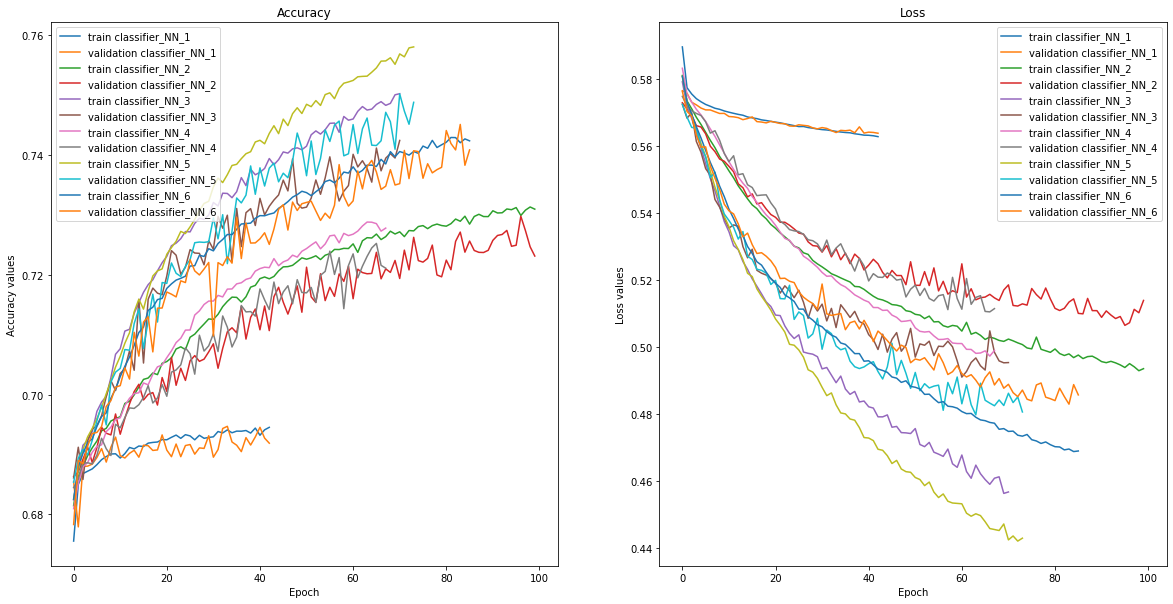

In [31]:
plot_liste_hist(liste_hist_nn, liste_NNStr)

Le EarlyStopping sur val_loss permet d'éviter l'overfitting qui semble ce produire après la 80eme epoch environ. On note quand même moins d'overfitting sur le modele 6 grâce au Dropout.

## CNN
Les modèles servant aux time series (Layer Conv1D) sont parfois aussi très efficaces sur ce genre de classification. On essaie donc également des modèles CNN Conv1D.

In [52]:
# Reshaping data au format (n_samples, n_timesteps, n_features)
X_train_conv = X_train.to_numpy()
X_train_conv = X_train_conv.reshape(X_train_conv.shape[0], X_train_conv.shape[1],1)
print(X_train_conv.shape)
X_val_conv = X_val.to_numpy()
X_val_conv = X_val_conv.reshape(X_val_conv.shape[0], X_val_conv.shape[1],1)
print(X_val_conv.shape)
X_test2_conv = X_test2.to_numpy()
X_test2_conv = X_test2_conv.reshape(X_test2_conv.shape[0], X_test2_conv.shape[1],1)
print(X_test2_conv.shape)

(165768, 20, 1)
(35522, 20, 1)
(35522, 20, 1)


In [64]:
def create_model_conv1D():
    
    model = Sequential()
    model.add(Conv1D(20, 4, input_shape = X_train_conv.shape[1:], activation = 'relu'))
    model.add(MaxPooling1D(2))
    model.add(Flatten())
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    
    return model

def create_model_conv1D_2():
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=X_train_conv.shape[1:]))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [65]:
classifier_CNN_1 = KerasClassifier(build_fn=create_model_conv1D, batch_size=128, epochs=100, verbose=1, validation_data=(X_val_conv, y_val))
classifier_CNN_2 = KerasClassifier(build_fn=create_model_conv1D_2, batch_size=128, epochs=100, verbose=1, validation_data=(X_val_conv, y_val))

liste_CNN = [classifier_CNN_1, classifier_CNN_2]
liste_CNNStr = ["classifier_CNN_1", "classifier_CNN_2"]

In [67]:
liste_hist_cnn, temps_cnn = fitmodelskeras(liste_CNN,liste_CNNStr, X_train_conv, y_train)

Epoch 1/100
1296/1296 [==============================] - 3s 2ms/step - loss: 0.6017 - accuracy: 0.6733 - val_loss: 0.5822 - val_accuracy: 0.6838
Epoch 2/100
1296/1296 [==============================] - 2s 2ms/step - loss: 0.5825 - accuracy: 0.6856 - val_loss: 0.5795 - val_accuracy: 0.6830
Epoch 3/100
1296/1296 [==============================] - 2s 1ms/step - loss: 0.5820 - accuracy: 0.6847 - val_loss: 0.5780 - val_accuracy: 0.6838
Epoch 4/100
1296/1296 [==============================] - 2s 1ms/step - loss: 0.5796 - accuracy: 0.6850 - val_loss: 0.5770 - val_accuracy: 0.6836
Epoch 5/100
1296/1296 [==============================] - 2s 1ms/step - loss: 0.5778 - accuracy: 0.6863 - val_loss: 0.5761 - val_accuracy: 0.6847
Epoch 6/100
1296/1296 [==============================] - 2s 1ms/step - loss: 0.5773 - accuracy: 0.6860 - val_loss: 0.5780 - val_accuracy: 0.6824
Epoch 7/100
1296/1296 [==============================] - 2s 1ms/step - loss: 0.5772 - accuracy: 0.6861 - val_loss: 0.5768 - val_ac

Epoch 13/100
1296/1296 [==============================] - 11s 8ms/step - loss: 0.5665 - accuracy: 0.6952 - val_loss: 0.5620 - val_accuracy: 0.6969
Epoch 14/100
1296/1296 [==============================] - 11s 8ms/step - loss: 0.5629 - accuracy: 0.6989 - val_loss: 0.5647 - val_accuracy: 0.6985
Epoch 15/100
1296/1296 [==============================] - 11s 9ms/step - loss: 0.5622 - accuracy: 0.7011 - val_loss: 0.5618 - val_accuracy: 0.6980
Epoch 16/100
1296/1296 [==============================] - 10s 8ms/step - loss: 0.5620 - accuracy: 0.7002 - val_loss: 0.5640 - val_accuracy: 0.7057
Epoch 17/100
1296/1296 [==============================] - 11s 8ms/step - loss: 0.5626 - accuracy: 0.6993 - val_loss: 0.5598 - val_accuracy: 0.7023
Epoch 18/100
1296/1296 [==============================] - 10s 8ms/step - loss: 0.5588 - accuracy: 0.7042 - val_loss: 0.5599 - val_accuracy: 0.7024
Epoch 19/100
1296/1296 [==============================] - 10s 8ms/step - loss: 0.5580 - accuracy: 0.7024 - val_loss: 0

Epoch 69/100
1296/1296 [==============================] - 9s 7ms/step - loss: 0.5327 - accuracy: 0.7166 - val_loss: 0.5312 - val_accuracy: 0.7145
Epoch 70/100
1296/1296 [==============================] - 9s 7ms/step - loss: 0.5339 - accuracy: 0.7155 - val_loss: 0.5317 - val_accuracy: 0.7148
Epoch 71/100
1296/1296 [==============================] - 9s 7ms/step - loss: 0.5337 - accuracy: 0.7144 - val_loss: 0.5322 - val_accuracy: 0.7189
Epoch 72/100
1296/1296 [==============================] - 9s 7ms/step - loss: 0.5314 - accuracy: 0.7165 - val_loss: 0.5292 - val_accuracy: 0.7205
Epoch 73/100
1296/1296 [==============================] - 9s 7ms/step - loss: 0.5345 - accuracy: 0.7140 - val_loss: 0.5297 - val_accuracy: 0.7176
Epoch 74/100
1296/1296 [==============================] - 9s 7ms/step - loss: 0.5301 - accuracy: 0.7172 - val_loss: 0.5298 - val_accuracy: 0.7187
Epoch 75/100
1296/1296 [==============================] - 9s 7ms/step - loss: 0.5324 - accuracy: 0.7157 - val_loss: 0.5295 -

In [68]:
scores_cnn = scoremodels(liste_CNN, liste_CNNStr, X_test2_conv, y_test2)

278/278 [==============================] - 0s 939us/step - loss: 0.5711 - accuracy: 0.6942
---------------------------------
classifier_CNN_1 score : 0.6941613554954529
278/278 [==============================] - 0s 1ms/step - loss: 0.5226 - accuracy: 0.7252
---------------------------------
classifier_CNN_2 score : 0.7252407073974609


Les résultats n'ont pas été meilleurs que pour les modèles linéaires malgré des temps d'entraînement très long. Peu concluant.

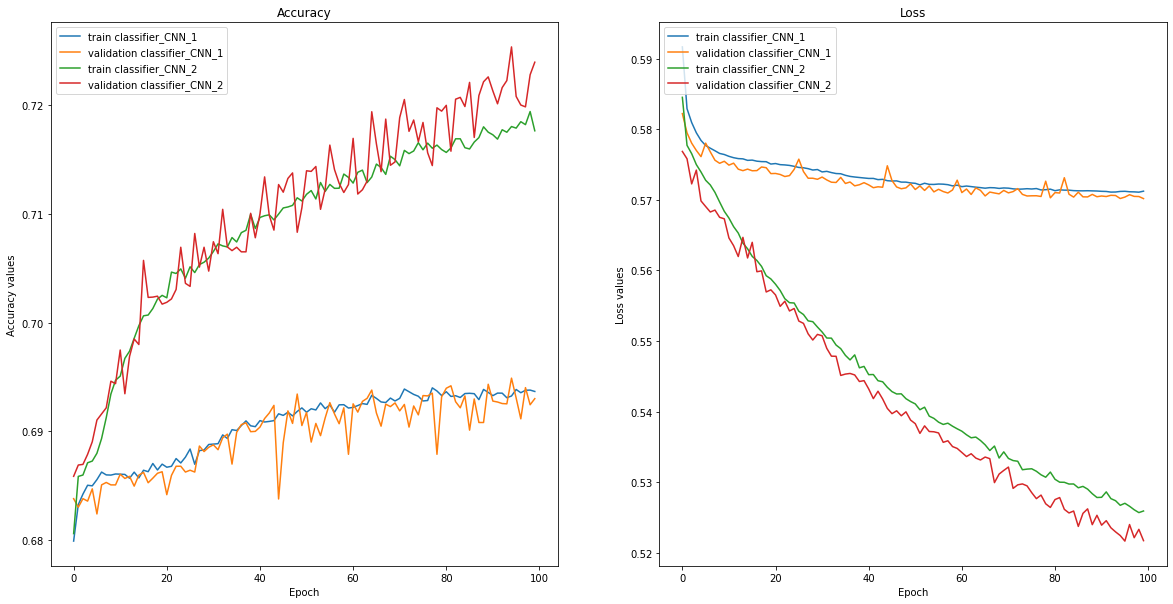

In [80]:
plot_liste_hist(liste_hist_cnn, liste_CNNStr)

## Grid Search

Nous allons effectuer un grid search pour essayer d'améliorer le modele Decision Tree et le modele 3 c'est neural network.

In [24]:
# Paramètres à tester pour le modele NN
optimizers = ['rmsprop', 'adam']
init = ['glorot_uniform', 'normal']
epochs = [100]
batches = [64, 128, 256]
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=10,
    restore_best_weights=True,
)
callbacks = [early_stopping]
validation_data = [(X_val, y_val)]
param_grid = dict(optimizer=optimizers, epochs=epochs, batch_size=batches, init=init, callbacks = callbacks, validation_data=validation_data)

# Paramètres à tester pour le modele decision tree
criterion = ["gini", "entropy"]
max_depth = [5*i for i in range(1,20)]
max_depth.append(None)
splitter = ["best", "random"]
param_gridDTC = dict(criterion= criterion, max_depth = max_depth, splitter = splitter)


def makegrid(model, X_train, y_train, param_grid=param_grid, cv = 2):
    grid = GridSearchCV(estimator=model, param_grid=param_grid, cv = cv, verbose = 0)
    grid_result = grid.fit(X_train, y_train)
    bestparam = grid_result.best_params_
    if 'validation_data' in bestparam:
        bestparam.pop('validation_data')
    if 'callbacks' in bestparam:
        bestparam.pop('callbacks')
    print("\nMeilleur cv score : %f avec %s" % (grid_result.best_score_, bestparam))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        if 'validation_data' in param:
            param.pop('validation_data')
        if 'callbacks' in param:
            param.pop('callbacks')
        print("\nScore cv : %f (std : %f) avec: %r" % (mean, stdev, param))
    return grid, grid_result

def create_model_DenseCV(optimizer='rmsprop', init='glorot_uniform'):
    model = Sequential()
    model.add(Dense(500, input_dim=20, kernel_initializer=init, activation='relu'))
    model.add(Dense(100, kernel_initializer=init, activation='relu'))
    model.add(Dense(50, kernel_initializer=init, activation='relu'))
    model.add(Dense(1, kernel_initializer=init, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [25]:
classifier_DenseCV = KerasClassifier(build_fn=create_model_DenseCV)

grid_Dense, grid_result_Dense = makegrid(classifier_DenseCV, X_train, y_train, param_grid=param_grid)

Epoch 1/100
1296/1296 [==============================] - 3s 2ms/step - loss: 0.5903 - accuracy: 0.6758 - val_loss: 0.5897 - val_accuracy: 0.6847
Epoch 2/100
1296/1296 [==============================] - 2s 1ms/step - loss: 0.5781 - accuracy: 0.6829 - val_loss: 0.5733 - val_accuracy: 0.6892
Epoch 3/100
1296/1296 [==============================] - 2s 1ms/step - loss: 0.5772 - accuracy: 0.6865 - val_loss: 0.5747 - val_accuracy: 0.6881
Epoch 4/100
1296/1296 [==============================] - 2s 1ms/step - loss: 0.5749 - accuracy: 0.6877 - val_loss: 0.5729 - val_accuracy: 0.6892
Epoch 5/100
1296/1296 [==============================] - 2s 1ms/step - loss: 0.5752 - accuracy: 0.6858 - val_loss: 0.5705 - val_accuracy: 0.6903
Epoch 6/100
1296/1296 [==============================] - 2s 2ms/step - loss: 0.5701 - accuracy: 0.6917 - val_loss: 0.5722 - val_accuracy: 0.6868
Epoch 7/100
1296/1296 [==============================] - 2s 1ms/step - loss: 0.5711 - accuracy: 0.6919 - val_loss: 0.5719 - val_ac

Epoch 1/100
1296/1296 [==============================] - 3s 2ms/step - loss: 0.5898 - accuracy: 0.6729 - val_loss: 0.5748 - val_accuracy: 0.6865
Epoch 2/100
1296/1296 [==============================] - 2s 2ms/step - loss: 0.5766 - accuracy: 0.6850 - val_loss: 0.5732 - val_accuracy: 0.6881
Epoch 3/100
1296/1296 [==============================] - 3s 2ms/step - loss: 0.5688 - accuracy: 0.6913 - val_loss: 0.5700 - val_accuracy: 0.6886
Epoch 4/100
1296/1296 [==============================] - 2s 2ms/step - loss: 0.5681 - accuracy: 0.6918 - val_loss: 0.5753 - val_accuracy: 0.6896
Epoch 5/100
1296/1296 [==============================] - 3s 2ms/step - loss: 0.5640 - accuracy: 0.6942 - val_loss: 0.5661 - val_accuracy: 0.6901
Epoch 6/100
1296/1296 [==============================] - 3s 2ms/step - loss: 0.5605 - accuracy: 0.6963 - val_loss: 0.5666 - val_accuracy: 0.6915
Epoch 7/100
1296/1296 [==============================] - 3s 2ms/step - loss: 0.5612 - accuracy: 0.6935 - val_loss: 0.5643 - val_ac

1296/1296 [==============================] - 2s 2ms/step - loss: 0.5505 - accuracy: 0.7044 - val_loss: 0.5594 - val_accuracy: 0.7014
Epoch 31/100
1296/1296 [==============================] - 2s 2ms/step - loss: 0.5499 - accuracy: 0.7062 - val_loss: 0.5654 - val_accuracy: 0.6983
Epoch 32/100
1296/1296 [==============================] - 2s 2ms/step - loss: 0.5511 - accuracy: 0.7028 - val_loss: 0.5663 - val_accuracy: 0.7015
Epoch 33/100
1296/1296 [==============================] - 2s 2ms/step - loss: 0.5478 - accuracy: 0.7062 - val_loss: 0.5698 - val_accuracy: 0.6980
Epoch 34/100
1296/1296 [==============================] - 2s 2ms/step - loss: 0.5488 - accuracy: 0.7061 - val_loss: 0.5678 - val_accuracy: 0.6975
Epoch 35/100
1296/1296 [==============================] - 2s 2ms/step - loss: 0.5487 - accuracy: 0.7063 - val_loss: 0.5643 - val_accuracy: 0.6984
Epoch 36/100
1296/1296 [==============================] - 2s 2ms/step - loss: 0.5477 - accuracy: 0.7068 - val_loss: 0.5632 - val_accuracy

648/648 [==============================] - 2s 2ms/step - loss: 0.5728 - accuracy: 0.6870 - val_loss: 0.5718 - val_accuracy: 0.6843
Epoch 5/100
648/648 [==============================] - 1s 2ms/step - loss: 0.5693 - accuracy: 0.6918 - val_loss: 0.5699 - val_accuracy: 0.6915
Epoch 6/100
648/648 [==============================] - 1s 2ms/step - loss: 0.5703 - accuracy: 0.6889 - val_loss: 0.5684 - val_accuracy: 0.6883
Epoch 7/100
648/648 [==============================] - 2s 2ms/step - loss: 0.5666 - accuracy: 0.6917 - val_loss: 0.5641 - val_accuracy: 0.6904
Epoch 8/100
648/648 [==============================] - 2s 3ms/step - loss: 0.5629 - accuracy: 0.6951 - val_loss: 0.5662 - val_accuracy: 0.6879
Epoch 9/100
648/648 [==============================] - 1s 2ms/step - loss: 0.5641 - accuracy: 0.6902 - val_loss: 0.5622 - val_accuracy: 0.6931
Epoch 10/100
648/648 [==============================] - 1s 2ms/step - loss: 0.5609 - accuracy: 0.6948 - val_loss: 0.5744 - val_accuracy: 0.6921
Epoch 11/1

648/648 [==============================] - 2s 2ms/step - loss: 0.5227 - accuracy: 0.7153 - val_loss: 0.5380 - val_accuracy: 0.7064
Epoch 26/100
648/648 [==============================] - 1s 2ms/step - loss: 0.5229 - accuracy: 0.7158 - val_loss: 0.5383 - val_accuracy: 0.7064
Epoch 27/100
648/648 [==============================] - 2s 2ms/step - loss: 0.5180 - accuracy: 0.7142 - val_loss: 0.5392 - val_accuracy: 0.7067
Epoch 28/100
648/648 [==============================] - 1s 2ms/step - loss: 0.5182 - accuracy: 0.7160 - val_loss: 0.5390 - val_accuracy: 0.7073
Epoch 29/100
648/648 [==============================] - 2s 3ms/step - loss: 0.5175 - accuracy: 0.7171 - val_loss: 0.5366 - val_accuracy: 0.7106
Epoch 30/100
648/648 [==============================] - 2s 2ms/step - loss: 0.5156 - accuracy: 0.7180 - val_loss: 0.5366 - val_accuracy: 0.7073
Epoch 31/100
648/648 [==============================] - 2s 2ms/step - loss: 0.5150 - accuracy: 0.7177 - val_loss: 0.5356 - val_accuracy: 0.7121: 0s -

648/648 [==============================] - 1s 2ms/step - loss: 0.5297 - accuracy: 0.7172 - val_loss: 0.5450 - val_accuracy: 0.7085
Epoch 42/100
648/648 [==============================] - 1s 2ms/step - loss: 0.5275 - accuracy: 0.7181 - val_loss: 0.5485 - val_accuracy: 0.7086
Epoch 43/100
648/648 [==============================] - 1s 2ms/step - loss: 0.5265 - accuracy: 0.7202 - val_loss: 0.5426 - val_accuracy: 0.7110
Epoch 44/100
648/648 [==============================] - 1s 2ms/step - loss: 0.5320 - accuracy: 0.7141 - val_loss: 0.5429 - val_accuracy: 0.7077
Epoch 45/100
648/648 [==============================] - 1s 2ms/step - loss: 0.5276 - accuracy: 0.7163 - val_loss: 0.5399 - val_accuracy: 0.7123
Epoch 46/100
648/648 [==============================] - 2s 3ms/step - loss: 0.5246 - accuracy: 0.7183 - val_loss: 0.5398 - val_accuracy: 0.7123
Epoch 47/100
648/648 [==============================] - 2s 3ms/step - loss: 0.5244 - accuracy: 0.7193 - val_loss: 0.5383 - val_accuracy: 0.7121
Epoch

648/648 [==============================] - 2s 2ms/step - loss: 0.5272 - accuracy: 0.7109 - val_loss: 0.5415 - val_accuracy: 0.7043
Epoch 29/100
648/648 [==============================] - 2s 2ms/step - loss: 0.5268 - accuracy: 0.7139 - val_loss: 0.5459 - val_accuracy: 0.7036
Epoch 30/100
648/648 [==============================] - 2s 2ms/step - loss: 0.5285 - accuracy: 0.7120 - val_loss: 0.5396 - val_accuracy: 0.7071
Epoch 31/100
648/648 [==============================] - 1s 2ms/step - loss: 0.5245 - accuracy: 0.7138 - val_loss: 0.5403 - val_accuracy: 0.7052
Epoch 32/100
648/648 [==============================] - 1s 2ms/step - loss: 0.5226 - accuracy: 0.7161 - val_loss: 0.5415 - val_accuracy: 0.7087
Epoch 33/100
648/648 [==============================] - 1s 2ms/step - loss: 0.5236 - accuracy: 0.7170 - val_loss: 0.5367 - val_accuracy: 0.7128
Epoch 34/100
648/648 [==============================] - 2s 2ms/step - loss: 0.5199 - accuracy: 0.7173 - val_loss: 0.5402 - val_accuracy: 0.7085
Epoch

324/324 [==============================] - 1s 3ms/step - loss: 0.5201 - accuracy: 0.7165 - val_loss: 0.5428 - val_accuracy: 0.7072
Epoch 40/100
324/324 [==============================] - 1s 3ms/step - loss: 0.5181 - accuracy: 0.7196 - val_loss: 0.5382 - val_accuracy: 0.7110
Epoch 41/100
324/324 [==============================] - 1s 3ms/step - loss: 0.5194 - accuracy: 0.7177 - val_loss: 0.5410 - val_accuracy: 0.7109
Epoch 42/100
324/324 [==============================] - 1s 3ms/step - loss: 0.5207 - accuracy: 0.7163 - val_loss: 0.5391 - val_accuracy: 0.7126
Epoch 43/100
324/324 [==============================] - 1s 3ms/step - loss: 0.5158 - accuracy: 0.7190 - val_loss: 0.5393 - val_accuracy: 0.7099
Epoch 44/100
324/324 [==============================] - 1s 3ms/step - loss: 0.5168 - accuracy: 0.7198 - val_loss: 0.5368 - val_accuracy: 0.7111
Epoch 45/100
324/324 [==============================] - 1s 3ms/step - loss: 0.5128 - accuracy: 0.7219 - val_loss: 0.5367 - val_accuracy: 0.7092
Epoch

324/324 [==============================] - 1s 3ms/step - loss: 0.5103 - accuracy: 0.7190 - val_loss: 0.5353 - val_accuracy: 0.7126
Epoch 41/100
324/324 [==============================] - 1s 3ms/step - loss: 0.5099 - accuracy: 0.7187 - val_loss: 0.5454 - val_accuracy: 0.7084
Epoch 42/100
324/324 [==============================] - 1s 3ms/step - loss: 0.5091 - accuracy: 0.7205 - val_loss: 0.5362 - val_accuracy: 0.7091
Epoch 43/100
324/324 [==============================] - 1s 3ms/step - loss: 0.5051 - accuracy: 0.7222 - val_loss: 0.5330 - val_accuracy: 0.7152
Epoch 44/100
324/324 [==============================] - 1s 3ms/step - loss: 0.5039 - accuracy: 0.7244 - val_loss: 0.5372 - val_accuracy: 0.7107
Epoch 45/100
324/324 [==============================] - 1s 3ms/step - loss: 0.5073 - accuracy: 0.7232 - val_loss: 0.5355 - val_accuracy: 0.7134
Epoch 46/100
324/324 [==============================] - 1s 3ms/step - loss: 0.5059 - accuracy: 0.7233 - val_loss: 0.5370 - val_accuracy: 0.7105
Epoch

324/324 [==============================] - 1s 3ms/step - loss: 0.5139 - accuracy: 0.7221 - val_loss: 0.5362 - val_accuracy: 0.7141
Epoch 51/100
324/324 [==============================] - 1s 3ms/step - loss: 0.5164 - accuracy: 0.7190 - val_loss: 0.5412 - val_accuracy: 0.7151
Epoch 52/100
324/324 [==============================] - 1s 3ms/step - loss: 0.5169 - accuracy: 0.7192 - val_loss: 0.5366 - val_accuracy: 0.7140
Epoch 53/100
324/324 [==============================] - 1s 3ms/step - loss: 0.5124 - accuracy: 0.7223 - val_loss: 0.5345 - val_accuracy: 0.7134
Epoch 54/100
324/324 [==============================] - 1s 3ms/step - loss: 0.5117 - accuracy: 0.7231 - val_loss: 0.5386 - val_accuracy: 0.7160
Epoch 55/100
324/324 [==============================] - 1s 3ms/step - loss: 0.5114 - accuracy: 0.7237 - val_loss: 0.5360 - val_accuracy: 0.7137
Epoch 56/100
324/324 [==============================] - 1s 3ms/step - loss: 0.5102 - accuracy: 0.7253 - val_loss: 0.5376 - val_accuracy: 0.7141
Epoch

324/324 [==============================] - 0s 1ms/step - loss: 0.5341 - accuracy: 0.7144
Epoch 1/100
324/324 [==============================] - 2s 4ms/step - loss: 0.6056 - accuracy: 0.6743 - val_loss: 0.5754 - val_accuracy: 0.6855
Epoch 2/100
324/324 [==============================] - 1s 3ms/step - loss: 0.5756 - accuracy: 0.6828 - val_loss: 0.5741 - val_accuracy: 0.6879
Epoch 3/100
324/324 [==============================] - 1s 3ms/step - loss: 0.5751 - accuracy: 0.6863 - val_loss: 0.5723 - val_accuracy: 0.6874
Epoch 4/100
324/324 [==============================] - 1s 3ms/step - loss: 0.5714 - accuracy: 0.6888 - val_loss: 0.5751 - val_accuracy: 0.6852
Epoch 5/100
324/324 [==============================] - 1s 3ms/step - loss: 0.5717 - accuracy: 0.6884 - val_loss: 0.5716 - val_accuracy: 0.6881
Epoch 6/100
324/324 [==============================] - 1s 3ms/step - loss: 0.5710 - accuracy: 0.6910 - val_loss: 0.5732 - val_accuracy: 0.6794
Epoch 7/100
324/324 [==============================] 

Epoch 6/100
1296/1296 [==============================] - 3s 2ms/step - loss: 0.5615 - accuracy: 0.6939 - val_loss: 0.5581 - val_accuracy: 0.6933
Epoch 7/100
1296/1296 [==============================] - 3s 2ms/step - loss: 0.5555 - accuracy: 0.6959 - val_loss: 0.5560 - val_accuracy: 0.6955
Epoch 8/100
1296/1296 [==============================] - 3s 2ms/step - loss: 0.5538 - accuracy: 0.6975 - val_loss: 0.5524 - val_accuracy: 0.6987
Epoch 9/100
1296/1296 [==============================] - 3s 2ms/step - loss: 0.5518 - accuracy: 0.6972 - val_loss: 0.5488 - val_accuracy: 0.6962
Epoch 10/100
1296/1296 [==============================] - 3s 2ms/step - loss: 0.5465 - accuracy: 0.6998 - val_loss: 0.5451 - val_accuracy: 0.7004
Epoch 11/100
1296/1296 [==============================] - 3s 2ms/step - loss: 0.5413 - accuracy: 0.7034 - val_loss: 0.5438 - val_accuracy: 0.7054
Epoch 12/100
1296/1296 [==============================] - 3s 2ms/step - loss: 0.5387 - accuracy: 0.7057 - val_loss: 0.5400 - val

In [26]:
grid_Dense.score(X_test2, y_test2)

278/278 [==============================] - 0s 1ms/step - loss: 0.4949 - accuracy: 0.7406


0.7405833005905151

Pas d'amélioration après grid search.

#### Grid search sur DTC

In [27]:
grid_DTC, grid_result_DTC = makegrid(DecisionTreeClassifier(random_state = 0), X_train, y_train, param_grid=param_gridDTC, cv = 5)


Meilleur cv score : 0.809994 avec {'criterion': 'entropy', 'max_depth': 80, 'splitter': 'best'}

Score cv : 0.684939 (std : 0.002371) avec: {'criterion': 'gini', 'max_depth': 5, 'splitter': 'best'}

Score cv : 0.673604 (std : 0.002304) avec: {'criterion': 'gini', 'max_depth': 5, 'splitter': 'random'}

Score cv : 0.712152 (std : 0.000832) avec: {'criterion': 'gini', 'max_depth': 10, 'splitter': 'best'}

Score cv : 0.689590 (std : 0.002906) avec: {'criterion': 'gini', 'max_depth': 10, 'splitter': 'random'}

Score cv : 0.732693 (std : 0.000829) avec: {'criterion': 'gini', 'max_depth': 15, 'splitter': 'best'}

Score cv : 0.704660 (std : 0.002059) avec: {'criterion': 'gini', 'max_depth': 15, 'splitter': 'random'}

Score cv : 0.758868 (std : 0.001975) avec: {'criterion': 'gini', 'max_depth': 20, 'splitter': 'best'}

Score cv : 0.735088 (std : 0.005460) avec: {'criterion': 'gini', 'max_depth': 20, 'splitter': 'random'}

Score cv : 0.782745 (std : 0.002720) avec: {'criterion': 'gini', 'max_de

In [28]:
grid_DTC.score(X_test, y_test)

0.8213642249873317

Pas d'amélioration non plus.

## Conclusion 

Le meilleur résultat obtenu est d'un peu plus de 82% de bonnes prédictions avec l'estimateur DecisionTreeClassifier. Ce résultat semble difficilement améliorable et semble un bon résultat.

On atteint étagalement un peu plus de 74% de bonnes réponses avec un modele à réseaux de neuronnes. Cela est moins bon mais il serait sûrement possible d'atteindre 82% avec un peu plus de tuning.